In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

In [5]:
timed_df = pd.read_csv("close_dupli.csv")
timed_df.fillna(0, inplace=True)


timed_df['Date'] = pd.to_datetime(timed_df['Date'])
timed_df.set_index('Date', inplace=True)
# timed_df = timed_df.drop(columns='Date')


# Drop columns where every entry is 0.0
timed_df = timed_df.loc[:, (timed_df != 0).any(axis=0)]


# # # Use the column selection to drop columns where less than the threshold number of values are non-zero
threshold = 0.70 * len(timed_df)
timed_df = timed_df.loc[:, (timed_df != 0).sum() >= threshold]

In [7]:
# Assuming timed_df is your DataFrame indexed by date

# Set the desired start and end dates
start_date = '2019-09-19'
end_date = '2024-08-02'

# Use loc to select rows within the specified date range
timed_df = timed_df.loc[start_date:end_date]

# Set the desired number of columns to keep
num_columns_to_keep = 50  # Replace with your desired number

# first num columns
# timed_df = timed_df.iloc[:, :num_columns_to_keep]

# last num columns
# timed_df = timed_df.iloc[:, -num_columns_to_keep:]

timed_df = timed_df.replace(0, np.nan).ffill()
timed_df = timed_df.replace(0, np.nan).bfill()
# random num columns


timed_df = timed_df.sample(n=num_columns_to_keep, axis=1)


timed_df.isna().sum().sum()

0

In [8]:
timed_df.head()

,FLUIDOM,NATPLASTI,CELEBRITY,WINSOME,VAMSHIRU,NDLVENTURE,LUPIN,GMRINFRA,MFLINDIA,TCMLMTD,...,SDBL,UCOBANK,PRADPME,KCLINFRA,MITSHI,CONTROLPR,IVP,SIPL,MULLER,SLSTLQ
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-19,87.000000,36.000000,7.10,0.95,22.700001,329.799988,741.349976,15.900000,0.19,51.0,...,59.500000,14.65,50.000000,0.84,58.750000,244.800003,66.500000,14.6,26.1,12.51
2019-09-20,87.900002,36.000000,7.10,0.95,22.000000,335.549988,756.099976,16.700001,0.19,51.0,...,60.674999,14.70,52.299999,0.84,60.150002,237.800003,65.099998,14.6,26.1,12.51
2019-09-23,93.199997,36.450001,7.10,0.95,21.450001,342.000000,732.400024,16.650000,0.19,51.0,...,60.900002,14.90,54.799999,0.84,60.200001,244.000000,67.900002,14.6,26.1,12.51
2019-09-24,95.650002,36.599998,7.10,0.94,21.000000,342.000000,738.799988,17.150000,0.19,51.0,...,62.200001,14.85,54.799999,0.84,62.099998,242.899994,67.000000,14.6,26.1,12.51
2019-09-25,96.949997,37.150002,7.01,0.94,19.950001,339.350006,730.950012,16.799999,0.19,51.0,...,61.525002,14.30,54.150002,0.84,63.549999,241.699997,67.000000,14.6,26.1,12.51


In [16]:
# create portfolio optimization function using Monte Carlo simulation
def portfolio_optimization(timed_df, num_portfolios=100000):
    # Calculate the expected returns and the annualized sample covariance matrix of the daily asset returns
    mu = timed_df.pct_change().mean()
    Sigma = timed_df.pct_change().cov()

    # Set the number of assets
    num_assets = len(timed_df.columns)

    # Initialize an array to hold the results
    results = np.zeros((4 + num_assets, num_portfolios))

    for i in range(num_portfolios):
        # Select random weights and normalize to set the sum to 1
        weights = np.array(np.random.random(num_assets))
        weights /= np.sum(weights)

        # Calculate the portfolio return and volatility
        portfolio_return = np.sum(mu * weights) * 252
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights))) * np.sqrt(252)

        # Store the results in the array
        results[0, i] = portfolio_return
        results[1, i] = portfolio_std_dev
        # Store the Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
        results[2, i] = results[0, i] / results[1, i]
        # Iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results[j + 3, i] = weights[j]

    # Create a DataFrame of the results
    results_frame = pd.DataFrame(results.T,
                                 columns=['ret', 'stdev', 'sharpe', ""]
                                   + [timed_df.columns[i] for i in range(num_assets)])

    # Locate the position of the portfolio with the highest Sharpe Ratio
    max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]

    # Locate the position of the portfolio with the minimum standard deviation
    min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]

    return results_frame, max_sharpe_port, min_vol_port

In [17]:
portfolio_optimization(timed_df, num_portfolios=100)

(         ret     stdev    sharpe   unknown   FLUIDOM  NATPLASTI  CELEBRITY  \
 0   0.410075  0.162036  2.530764  0.011170  0.003279   0.014080   0.009248   
 1   0.457853  0.246515  1.857299  0.017254  0.002647   0.016299   0.038753   
 2   0.413469  0.184033  2.246710  0.010335  0.027348   0.019861   0.016746   
 3   0.474755  0.242505  1.957714  0.003082  0.036409   0.022697   0.038342   
 4   0.413230  0.161623  2.556756  0.016625  0.004562   0.035701   0.009033   
 ..       ...       ...       ...       ...       ...        ...        ...   
 95  0.445982  0.213043  2.093391  0.021191  0.032501   0.023497   0.026152   
 96  0.437366  0.263394  1.660502  0.012688  0.017622   0.000797   0.043141   
 97  0.380968  0.157542  2.418196  0.017036  0.021715   0.027384   0.006659   
 98  0.387090  0.172535  2.243537  0.010272  0.012642   0.009879   0.008273   
 99  0.439020  0.232060  1.891836  0.019991  0.024940   0.008204   0.031468   
 
      WINSOME  VAMSHIRU  NDLVENTURE  ...      SDBL

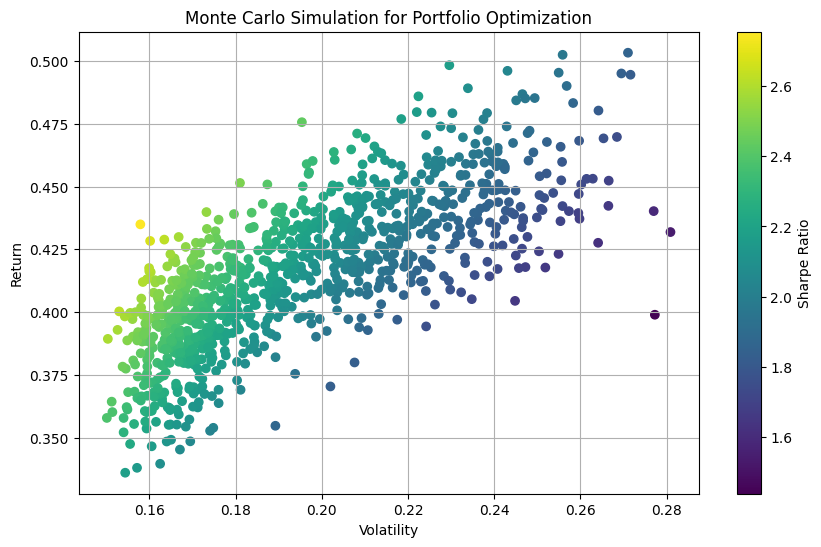

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sample data (replace this with your actual dataframe)
# Assuming dataframe has columns for different stocks and rows are date-indexed close prices
# Here, I'll just generate some random data for demonstration
np.random.seed(42)
num_years = 5
num_days_per_year = 252
num_simulations = 1000

df = timed_df
num_stocks = len(df.columns)

# Define portfolio weights (initial guess)
weights = np.random.random(num_stocks)
weights /= np.sum(weights)

# Calculate returns and covariance matrix
returns = df.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Monte Carlo simulation
portfolio_returns = []
portfolio_volatilities = []

for _ in range(num_simulations):
    # Generate random weights
    weights = np.random.random(num_stocks)
    weights /= np.sum(weights)
    
    # Calculate portfolio returns and volatility
    portfolio_return = np.sum(mean_returns * weights) * num_days_per_year
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(num_days_per_year)
    
    portfolio_returns.append(portfolio_return)
    portfolio_volatilities.append(portfolio_volatility)

portfolio_returns = np.array(portfolio_returns)
portfolio_volatilities = np.array(portfolio_volatilities)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(portfolio_volatilities, portfolio_returns, c=portfolio_returns / portfolio_volatilities, marker='o')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Monte Carlo Simulation for Portfolio Optimization')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()

In [22]:
# Calculate optimal portfolio weights (for demonstration, let's assume maximizing Sharpe ratio)
from scipy.optimize import minimize


def negative_sharpe_ratio(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights) * num_days_per_year
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(
        cov_matrix, weights))) * np.sqrt(num_days_per_year)
    sharpe_ratio = -portfolio_return / portfolio_volatility
    return sharpe_ratio


def optimize_portfolio(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    initial_guess = num_assets * [1. / num_assets,]
    optimal_weights = minimize(negative_sharpe_ratio, initial_guess, args=(mean_returns, cov_matrix,),
                               method='SLSQP', bounds=bounds, constraints=constraints)
    return optimal_weights.x


optimal_weights = optimize_portfolio(mean_returns, cov_matrix)

# Display optimal portfolio with allocation percentages
allocation_df = pd.DataFrame(
    {'Stock': df.columns, 'Allocation (%)': optimal_weights * 100})
print(allocation_df)

         Stock  Allocation (%)
0      FLUIDOM    2.087000e+00
1    NATPLASTI    3.437299e+00
2    CELEBRITY    0.000000e+00
3      WINSOME    2.915803e-01
4     VAMSHIRU    2.128897e+00
5   NDLVENTURE    4.212875e-14
6        LUPIN    1.269529e+00
7     GMRINFRA    2.335467e+00
8     MFLINDIA    2.822455e+00
9      TCMLMTD    1.433531e-14
10     CHITRTX    1.656860e+01
11     GUJHOTE    6.347246e-15
12    GLITTEKG    2.919827e+00
13    UNIVARTS    1.254688e+01
14       SUNTV    0.000000e+00
15       ASTAR    3.450503e-14
16    INDOAMIN    1.127905e-13
17  MANALIPETC    3.322677e-14
18    MANSIFIN    1.999346e+00
19     ANSALBU    1.071488e-14
20   ALPINEHOU    4.654625e+00
21     ARYAMAN    4.618364e+00
22    ROOPAIND    4.315498e+00
23     JINDHOT    0.000000e+00
24      SAMPRE    2.702057e+00
25    SMLISUZU    3.441554e-14
26    ROYALIND    2.011063e+00
27  WOCKPHARMA    0.000000e+00
28   SWELECTES    1.834620e+00
29     NACLIND    0.000000e+00
30     GUJCONT    9.219632e+00
31   RIS

In [24]:
# remove weights that are less than 0.01
allocation_df = allocation_df[allocation_df['Allocation (%)'] > 0.01]

In [29]:
for i in range(len(allocation_df)):
    print(f"{allocation_df['Stock'].iloc[i]} {allocation_df['Allocation (%)'].iloc[i] :.2f}%")

FLUIDOM 2.09%
NATPLASTI 3.44%
WINSOME 0.29%
VAMSHIRU 2.13%
LUPIN 1.27%
GMRINFRA 2.34%
MFLINDIA 2.82%
CHITRTX 16.57%
GLITTEKG 2.92%
UNIVARTS 12.55%
MANSIFIN 2.00%
ALPINEHOU 4.65%
ARYAMAN 4.62%
ROOPAIND 4.32%
SAMPRE 2.70%
ROYALIND 2.01%
SWELECTES 1.83%
GUJCONT 9.22%
RISHIROOP 1.95%
ESHAMEDIA 0.50%
JASCH 2.63%
SDBL 1.23%
UCOBANK 0.35%
KCLINFRA 0.57%
IVP 0.93%
SIPL 0.42%
MULLER 8.37%
SLSTLQ 5.27%
